# Building a Language Model Using Histogram N-Gram Analysis

Installing required libraries
Install these libraries using the code cell below.

After installing the libraries below please RESTART THE KERNEL and run all cells.

In [ ]:
%%capture
!pip install nltk
!pip install scikit-learn
!pip install torch==2.6.0
!pip install torchtext==0.17.2
!pip install matplotlib
!pip install pandas
!pip install numpy==1.26.4

In [ ]:
# @title Importing required libraries

%%capture
import warnings
from tqdm import tqdm

warnings.simplefilter('ignore')
import time
from collections import OrderedDict

import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string
import time

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
%capture

In [ ]:
# @title Define a support function

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

## Language Modeling

Language modeling is a foundational concept within the field of natural language processing (NLP) and artificial intelligence. It involves the prediction of the likelihood of a sequence of words within a given language. This method is statistical in nature and seeks to capture the patterns, structures, and relationships that exist between words in a given text corpus.

At its essence, a language model strives to comprehend the probabilities associated with sequences of words. This comprehension can be leveraged for a multitude of NLP tasks, including but not limited to text generation, machine translation, speech recognition, sentiment analysis, and more.

Let's consider the following song lyrics to determine if you can generate similar output using a given word.

In [ ]:
song = """ It's been a long time since I rock and rolled
It's been a long time since I did the stroll
Ooh, let me get it back, let me get it back
Let me get it back, baby, where I come from
It's been a long time, been a long time
Been a long lonely, lonely, lonely, lonely, lonely time
Yes, it has
It's been a long time since the Book of Love
I can't count the tears of a life with no love
Carry me back, carry me back
Carry me back, baby, where I come from
Whoa, whoa, oh
It's been a long time, been a long time
Been a long lonely, lonely, lonely, lonely, lonely time
Oh, seems so long since we walked in the moonlight
Making vows that just can't work right
Oh yeah, open your arms, opens your arms
Open your arms, baby, let my love come running in
Yeah!
It's been a long time, been a long time
Been a long lonely, lonely, lonely, lonely, lonely time
Yeah, yeah
Yeah, yeah
Ooh yeah, ooh yeah
Ooh yeah, ooh yeah
It's been a long time, been a long time
Been a long lonely, lonely, lonely, lonely, lonely time"""

### Natural Language Toolkit (NLTK)

NLTK is indeed a widely-used open-source library in Python that is specifically designed for various natural language processing (NLP) tasks. It provides a comprehensive set of tools, resources, and algorithms that aid in the analysis and manipulation of human language data.

### Tokenization

Tokenization is the process of breaking down a body of text into discrete units known as tokens. For this project, we will focus on Word Tokenization, this technique treats each word in the text as an independent entity. Words, typically separated by spaces or punctuation marks, serve as the tokens in this approach. It's important to note that Word Tokenization exhibits versatile characteristics, including capitalization, symbols, and punctuation marks.

We will utilize the```word_tokenize```function. During this process, we will remove punctuation, symbols, and capital letters.

In [ ]:
from nltk.tokenize import word_tokenize
def preprocess(words):
    tokens=word_tokenize(words)
    tokens=[preprocess_string(w)   for w in tokens]
    return [w.lower()  for w in tokens if len(w)!=0 or not(w in string.punctuation) ]

tokens=preprocess(song)

In [ ]:
tokens[0:11]

['it', 's', 'been', 'a', 'long', 'time', 'since', 'i', 'rock', 'and', 'rolled']

In [ ]:
# @title Create a frequency distribution of words
fdist = nltk.FreqDist(tokens)
fdist

FreqDist({'lonely': 20, 'a': 16, 'long': 16, 'been': 15, 'time': 15, 'it': 11, 'yeah': 10, 's': 7, 'me': 6, 'back': 6, ...})

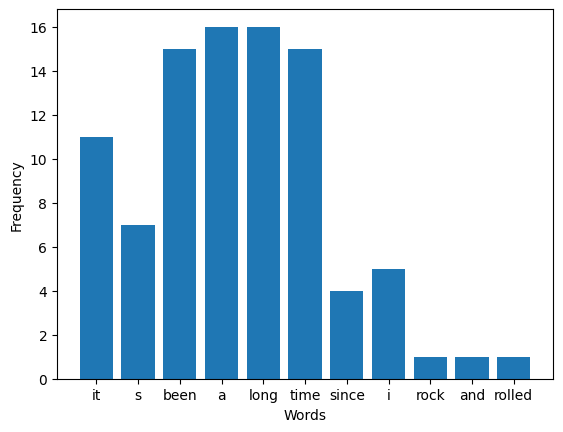

In [ ]:
# @title Plot the words with the top ten frequencies.

plt.bar(list(fdist.keys())[0:11],list(fdist.values())[0:11])
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

### Unigram model
An unigram model is a simple type of language model that considers each word in a sequence independently, without taking into account the previous words. In other words, it models the probability of each word occurring in the text, regardless of what came before it. Unigram models can be seen as a special case of n-gram models, where n is 1.

In [ ]:
#total count of each word

C=sum(fdist.values())
C

211

In [ ]:
fdist['rock']/C

0.004739336492890996

In [ ]:
vocabulary=set(tokens)
vocabulary

{'a',
 'and',
 'arms',
 'baby',
 'back',
 'been',
 'book',
 'ca',
 'carry',
 'come',
 'count',
 'did',
 'from',
 'get',
 'has',
 'i',
 'in',
 'it',
 'just',
 'let',
 'life',
 'lonely',
 'long',
 'love',
 'making',
 'me',
 'moonlight',
 'my',
 'no',
 'nt',
 'of',
 'oh',
 'ooh',
 'open',
 'opens',
 'right',
 'rock',
 'rolled',
 'running',
 's',
 'seems',
 'since',
 'so',
 'stroll',
 'tears',
 'that',
 'the',
 'time',
 'vows',
 'walked',
 'we',
 'where',
 'whoa',
 'with',
 'work',
 'yeah',
 'yes',
 'your'}

### Bigram Model

Bigram models use conditional probability. The probability of a word depends only on the previous word, i.e., the conditional probability  is used to predict the likelihood of word following word  in a sequence. You can calculate the conditional probability for a bigram model using the following steps.

In [ ]:
bigrams = nltk.bigrams(tokens)
bigrams

<generator object bigrams at 0x79e506862880>

In [ ]:
my_bigrams=list(nltk.bigrams(tokens))

In [ ]:
my_bigrams[0:10]

[('it', 's'),
 ('s', 'been'),
 ('been', 'a'),
 ('a', 'long'),
 ('long', 'time'),
 ('time', 'since'),
 ('since', 'i'),
 ('i', 'rock'),
 ('rock', 'and'),
 ('and', 'rolled')]

In [ ]:
# @title Compute the frequency distribution of the bigram using the NLTK function bigrams.

freq_bigrams  = nltk.FreqDist(nltk.bigrams(tokens))
freq_bigrams

FreqDist({('lonely', 'lonely'): 16, ('been', 'a'): 15, ('a', 'long'): 15, ('long', 'time'): 11, ('time', 'been'): 8, ('it', 's'): 7, ('s', 'been'): 7, ('long', 'lonely'): 4, ('lonely', 'time'): 4, ('yeah', 'ooh'): 4, ...})

In [ ]:
freq_bigrams[('rock', 'and')]

1

In [ ]:
# @title The first 10 values of the frequency distribution

for my_bigram in  my_bigrams[0:10]:
    print(my_bigram)
    print(freq_bigrams[my_bigram])

('it', 's')
7
('s', 'been')
7
('been', 'a')
15
('a', 'long')
15
('long', 'time')
11
('time', 'since')
3
('since', 'i')
2
('i', 'rock')
1
('rock', 'and')
1
('and', 'rolled')
1


In [ ]:
# @title Generate the conditional distribution
# by normalizing the frequency distribution of unigrams.

word="time"
vocab_probabilities={}
for next_word in vocabulary:
    vocab_probabilities[next_word]=freq_bigrams[(word,next_word)]/fdist[word]

vocab_probabilities=sorted(vocab_probabilities.items(), key=lambda x:x[1],reverse=True)

vocab_probabilities[0:4]

[('been', 0.5333333333333333),
 ('since', 0.2),
 ('yes', 0.06666666666666667),
 ('yeah', 0.06666666666666667)]

Define a function to calculate the conditional probability
of $W_t$ given $W_{t-1}$, sort the results, and output them as a list.

In [ ]:

def make_predictions(my_words, freq_grams, normlize=1, vocabulary=vocabulary):
    """
    Generate predictions for the conditional probability of the next word given a sequence.

    Args:
        my_words (list): A list of words in the input sequence.
        freq_grams (dict): A dictionary containing frequency of n-grams.
        normlize (int): A normalization factor for calculating probabilities.
        vocabulary (list): A list of words in the vocabulary.

    Returns:
        list: A list of predicted words along with their probabilities, sorted in descending order.
    """

    vocab_probabilities = {}  # Initialize a dictionary to store predicted word probabilities

    context_size = len(list(freq_grams.keys())[0])  # Determine the context size from n-grams keys

    # Preprocess input words and take only the relevant context words
    my_tokens = preprocess(my_words)[0:context_size - 1]

    # Calculate probabilities for each word in the vocabulary given the context
    for next_word in vocabulary:
        temp = my_tokens.copy()
        temp.append(next_word)  # Add the next word to the context

        # Calculate the conditional probability using the frequency information
        if normlize!=0:
            vocab_probabilities[next_word] = freq_grams[tuple(temp)] / normlize
        else:
            vocab_probabilities[next_word] = freq_grams[tuple(temp)]
    # Sort the predicted words based on their probabilities in descending order
    vocab_probabilities = sorted(vocab_probabilities.items(), key=lambda x: x[1], reverse=True)

    return vocab_probabilities  # Return the sorted list of predicted words and their probabilities

In [ ]:
my_words="long"

vocab_probabilities=make_predictions(my_words,freq_bigrams,normlize=fdist['i'])

vocab_probabilities[0:10]

[('time', 2.2),
 ('lonely', 0.8),
 ('since', 0.2),
 ('let', 0.0),
 ('stroll', 0.0),
 ('tears', 0.0),
 ('carry', 0.0),
 ('my', 0.0),
 ('making', 0.0),
 ('get', 0.0)]

In [ ]:
vocab_probabilities[0][0]

'time'

In [ ]:
# @title Generate a sequence using the bigram model
# by leveraging the preceding word (t-1) to predict the subsequent word.

my_song=""
for w in tokens[0:100]:
  my_word=make_predictions(w,freq_bigrams)[0][0]
  my_song+=" "+my_word

In [ ]:

my_song

' s been a long time been i come and rolled it s been a long time been i come the stroll ooh yeah me get it s let me get it s let me get it s let where i come from it s been a long time been a long time been a long time lonely lonely lonely lonely lonely been it s it s been a long time been i stroll of a carry come nt count the stroll of a long with no love carry me get let me get let me get let where i come'

In [ ]:
my_song="time"

for i in range(100):
    my_word=make_predictions(my_word,freq_bigrams)[0][0]
    my_song+=" "+my_word

In [ ]:
my_song

'time a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been a long time been'

## Trigram Model

Trigram models incorporate conditional probability as well. The probability of a word depends on the two preceding words. The conditional probability $P(W_t | W_{t-2}, W_{t-1})$ is utilized to predict the likelihood of word $W_t$ following the two previous words in a sequence. The context is $W_{t-2}, W_{t-1}$ and is of length 2.

In [ ]:
freq_trigrams  = nltk.FreqDist(nltk.trigrams(tokens))
freq_trigrams

FreqDist({('been', 'a', 'long'): 15, ('lonely', 'lonely', 'lonely'): 12, ('a', 'long', 'time'): 11, ('long', 'time', 'been'): 8, ('time', 'been', 'a'): 8, ('it', 's', 'been'): 7, ('s', 'been', 'a'): 7, ('a', 'long', 'lonely'): 4, ('long', 'lonely', 'lonely'): 4, ('lonely', 'lonely', 'time'): 4, ...})

In [ ]:
make_predictions("long time",freq_trigrams,normlize=freq_bigrams[('long','time')] )[0:10]

[('been', 0.7272727272727273),
 ('since', 0.2727272727272727),
 ('let', 0.0),
 ('stroll', 0.0),
 ('tears', 0.0),
 ('carry', 0.0),
 ('my', 0.0),
 ('making', 0.0),
 ('get', 0.0),
 ('yes', 0.0)]

In [57]:
my_song=""

w1=tokens[0]
for w2 in tokens[0:100]:
    gram=w1+' '+w2
    my_word=make_predictions(gram,freq_trigrams )[0][0]
    my_song+=" "+my_word
    w1=w2

In [58]:
my_song

' let been a long time been i rock and rolled it s been a long time been i rock the stroll ooh let me get it back let me get it back let me get it back let where i come from it s been a long time been a long time been a long time lonely lonely lonely lonely lonely yes it has it s been a long time been i book of love i ca nt count the tears of a life with no love carry me back carry me back carry me back carry where i come'